# Scale Up and Interpret Learning of the Fastai Classifier

## What's happening in this notebook? 

The first prototype created using the fastai framework was trained to distinguish between seven classes. In parallel to this, another prototype was created using the TensorFlow framework. Both used the same classes, but different image data. For upscaling to the second version we agreed to use 20 classes and compiled a common data set to increase comparability as well as reproducibility.
In this notebook, the fastai classifier will be scaled up to 20 classes using the common data set. Also, I will perform some hyperparameter tuning and test out different ResNet architectures. Beyond that, the learning of the neural network will be interpreted. A special emphasis is placed on performance and difficulties with regards to specific classes.

## Upscaling

### Image Data
In this notebook, the fastai classifier will be scaled up to 20 classes using the common data set.

For each class, we have just about 30 images. Since this is not a lot, we follow the "traditional" approach of splitting the data set into 80% training and 20% validation.

### Architecture
The first prototype trained on 7 classes used a ResNet18 (18 layers). 

Here, I will test all several different ResNets with different numbers of layers.

The following ResNet versions can be chosen from and passed to the fastai vision learner using the "arch" argument: 

`resnet18, resnet34, resnet50, resnet101, resnet152`

Architectures other than this are not tested in this specific notebook. To see fine tuning and interpretation of an Xception based model, please see the "classifier_tensorflow" directory. For a comparison of both, please have a look at our blog post in the base directory of this repo ("wt23-wastewise/blog.md").

The goal is to keep number of layers rather low to allow for quick execution and avoid extensive computation once the model is deployed as well as overfitting due to model complexity, while at the same time ensuring high accuracy.

#### No free lunch!
Following the conclusions of the "No Free Lunch" theorem, we do not expect any specific type of architecture/model to be the best one for all tasks. Each specific task has certain architectures that excel at it. Taking into consideration the nature of our task, which is image classification, we explored fine tuning several convolutional neural networks using transfer learning.

### Training and evaluation

#### Learning rate
For the first prototype trained on 7 classes, the default learning rate was used.
Here, a learning rate finder was used to determine the optimum learning rate. For each respective learner it is directly passed on to it in an argument.Generally, the optimum learning rate is either the minimum value divided by 10 or the steepest point. You can usually just choose one of both and typically these two are close together. To save one calculation, the steepest point will be used here.

#### Number of epochs
Training is done for more epochs than we expect to need to see the point at which training loss decreases while validation loss converges. This will be seen as the point at which the model starts to overfit and for the final training, the number of epochs will be adapted to prevent overfitting.

#### Metric and loss function
Error rate is used as metric (default).
Cross entropy loss is used as loss function (default).


## Discussion (Preview)
After exploring the different architectures and doing hyperparameter tuning, one setup will be decided for and an according learner will be fine tuned and exported.

# Preparations

In [ ]:
# connect colab to google drive by mounting
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# navigate to WasteWise directory
%cd drive/MyDrive/wt23-wastewise/AI/DL_data_preparation/classifier_fastai

In [ ]:
# see all current branch names including remote
! git branch -a

In [ ]:
# switch to feature branch
!git switch classifier_fastai

In [ ]:
# get latest version of all branches
!git pull --all

In [ ]:
# see version status of repository and branch
!git status

In [ ]:
# install the fastbook library
# for some reason, it needs to be reinstalled each time
# the flag "-Uqq" means that the output will be minimal to not overload the notebook
!pip install -Uqq fastbook

In [ ]:
# install further libraries that are not installed yet
!pip install -Uqq gradio

In [9]:
# import libraries
# fastbook/fastai related libraries: used for training the classifier
from fastbook import *
from fastai.vision.widgets import *

# enable operational system interface
import os

# disable warnings
# during training the following warning appears over and over again until the cell's output is hard to read
import warnings
warnings.filterwarnings('ignore')

# import gradio for deployment 
import gradio as gr

In [10]:
# set the path, where the image data is saved
# for upscaling, the common data set of 20 classes is used
path = Path('/content/drive/MyDrive/wt23-wastewise/AI/data_20_classes')

In [11]:
# print out files (in this case exclusively (sub)directories) in image data directory
# each (sub)directory corresponds to a class
# (sub)directory name will be used as label for the images
os.listdir(path)

['aluminum_foil',
 'apples',
 'banana_peels',
 'cardboard',
 'condoms',
 'diapers',
 'food_waste',
 'glass_bottle',
 'old_books',
 'oranges',
 'pans',
 'pizza_box',
 'plastic_bags',
 'plastic_packaging',
 'plastic_toys',
 'smartphone',
 'tampons',
 'tea_bags',
 'tetrapack',
 'toothbrush']

# Data Preparations

Prepare the DataBlock API loading the image batches to the learners and take a look at some of the images. They are prepared already, but it still is always a good idea to know your data!

In [12]:
# initialise the DataBlock API
waste = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
# make data loaders batches for handing to the classifier
dls = waste.dataloaders(path)

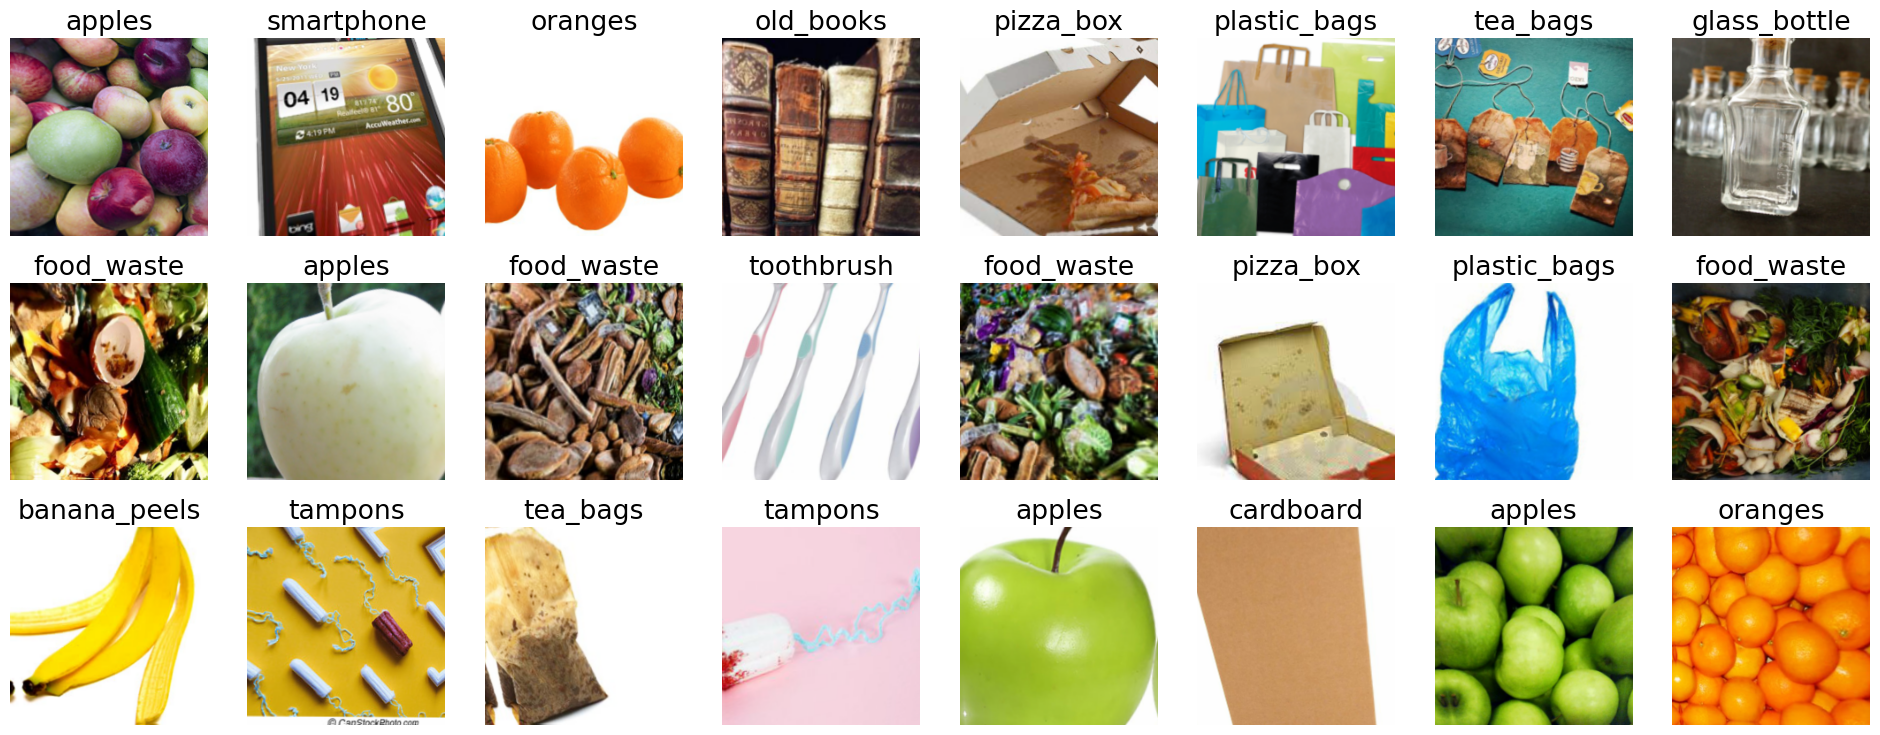

In [13]:
# display some of the image data from the training set to get a feel for it
# all images must be square. if they are not, they are resized
# default method for resizing is taking the center square
# since always taking the center square has its drawbacks,
# use the random resize to get a trade-off between different options

# set font size in plots
plt.rcParams.update({'font.size': 16})
dls.train.show_batch(max_n=24, nrows=3)

# ResNet18

Here the procedure is done for a ResNet18.

First the learner is defined. Afterwards the optimum learning rate is deterimined and the learner is fine tuned.

Training is done for at least 10 epochs to see the point at which training loss decreases while validation loss converges.

Finally, for interpretation, a confusion matrix and the top losses are displayed.

In [ ]:
# define a learner
learn_resnet18 = vision_learner(dls, arch = resnet18, metrics=error_rate)

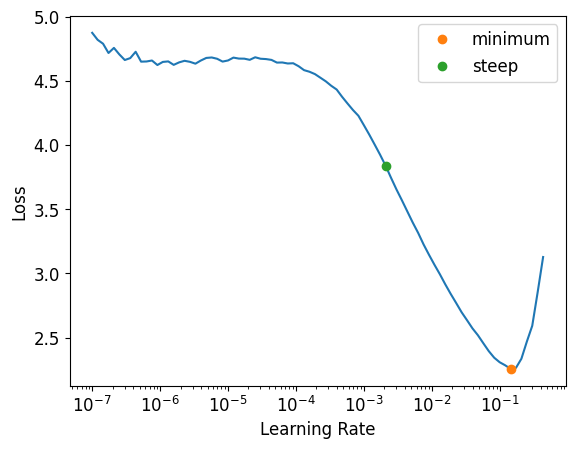

In [ ]:
# determine optimum learning rate
lr_min_resnet18,lr_steep_resnet18 = learn_resnet18.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
# minimum learning rate
lr_min_resnet18

0.014454397559165954

In [ ]:
# optimum learning rate
# this will be used and passed to the fine_tune method in an argument
lr_steep_resnet18

0.0020892962347716093

In [ ]:
# fine tune the learner for 10 epochs
learn_resnet18.fine_tune(10, base_lr = lr_steep_resnet18)

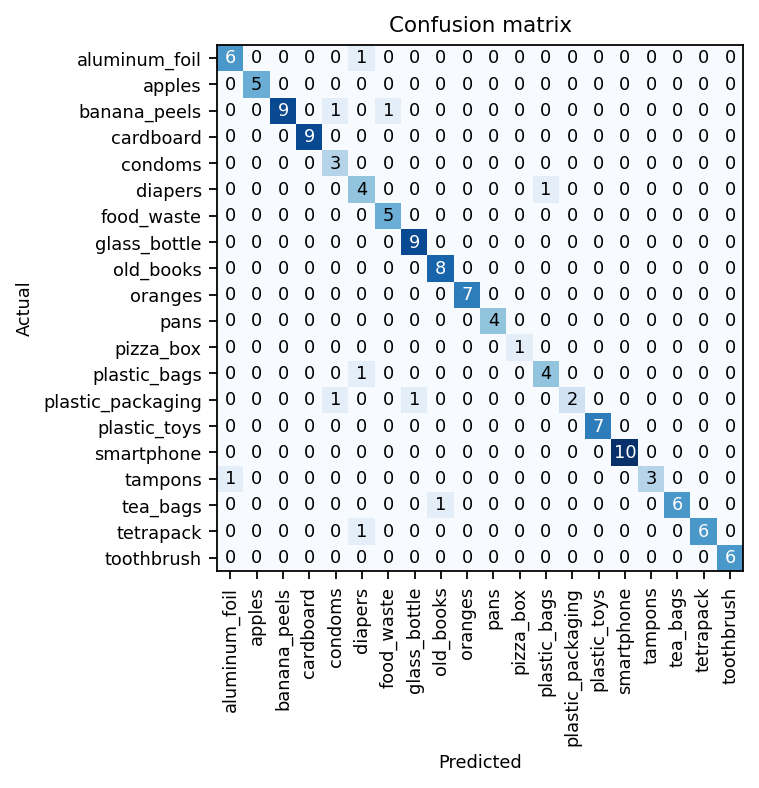

In [ ]:
# plot the confusion matrix

# set font size in plots
plt.rcParams.update({'font.size': 8})

# get results
interp_resnet18 = ClassificationInterpretation.from_learner(learn_resnet18)

# plot
interp_resnet18.plot_confusion_matrix(dpi = 160) # dpi adapts figure scaling

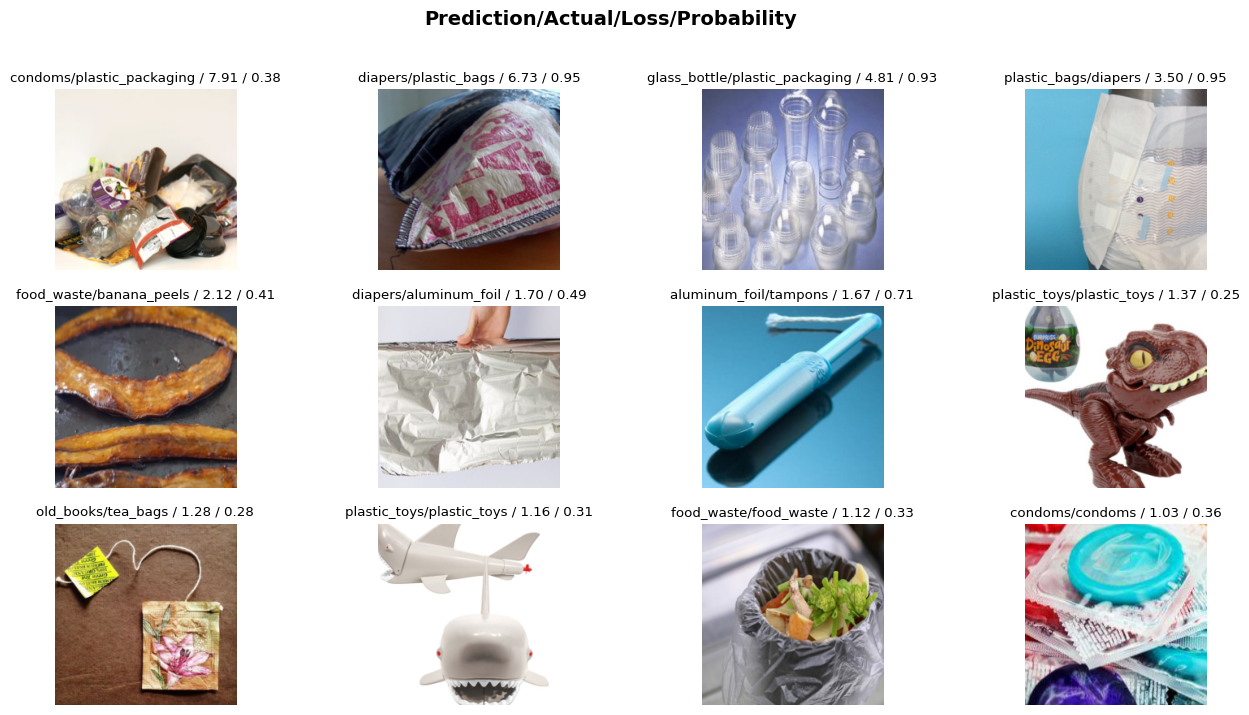

In [ ]:
# plot the top losses
# this corresponds to the falsely classified examples 
# as well as those the classifier was least confident with

# set font size in plots
plt.rcParams.update({'font.size': 8})
# default plot size for the top losses is 14. At that size, labels were overlapping and not even readable anymore as soon as there was more than one per line

# plot
interp_resnet18.plot_top_losses(12, nrows=3, figsize = (16, 8)) # arguments: number of items, number of rows to distribute items, size of figure

# ResNet34

For this ResNet34 and all the following ResNets in this notebook, the same procedure is repeated.

Redundant comments are removed, only the core explanation is kept. For detailed comments, refer to the ResNet18 section.

In [20]:
# define a learner
learn_resnet34 = vision_learner(dls, arch = resnet34, metrics=error_rate)

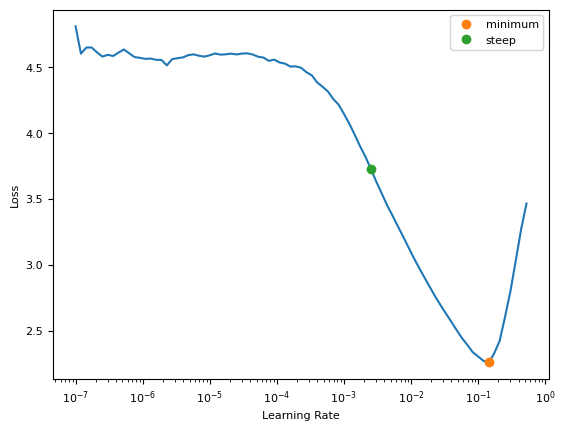

In [21]:
# determine optimum learning rate
lr_min_resnet34,lr_steep_resnet34 = learn_resnet34.lr_find(suggest_funcs=(minimum, steep))

In [22]:
# optimum learning rate
lr_steep_resnet34

0.002511886414140463

In [23]:
# fine tune the learner for 12 epochs
learn_resnet34.fine_tune(12, base_lr = lr_steep_resnet34)

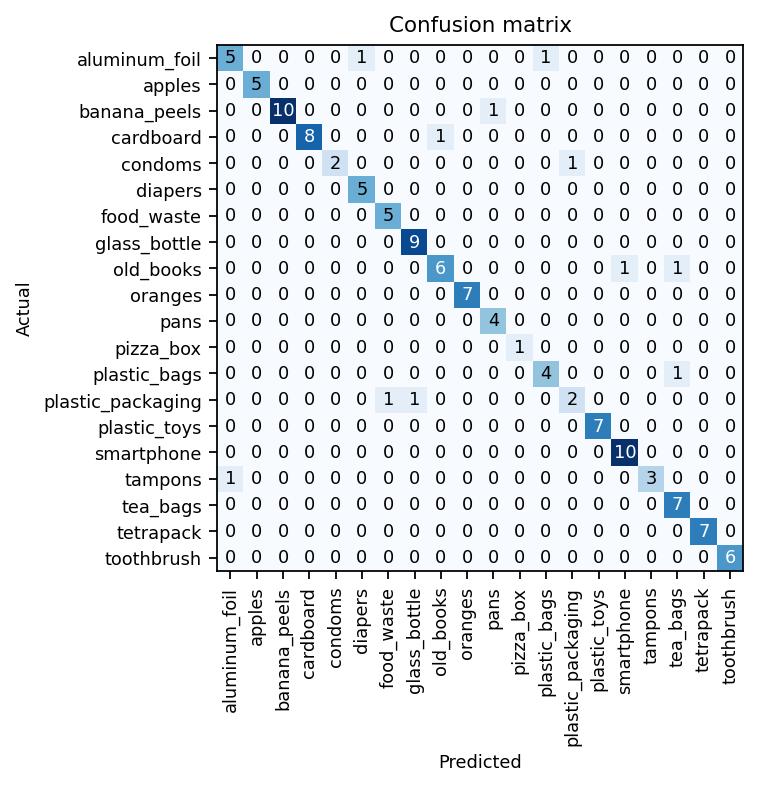

In [24]:
# plot the confusion matrix
plt.rcParams.update({'font.size': 8})
interp_resnet34 = ClassificationInterpretation.from_learner(learn_resnet34)
interp_resnet34.plot_confusion_matrix(dpi = 160)

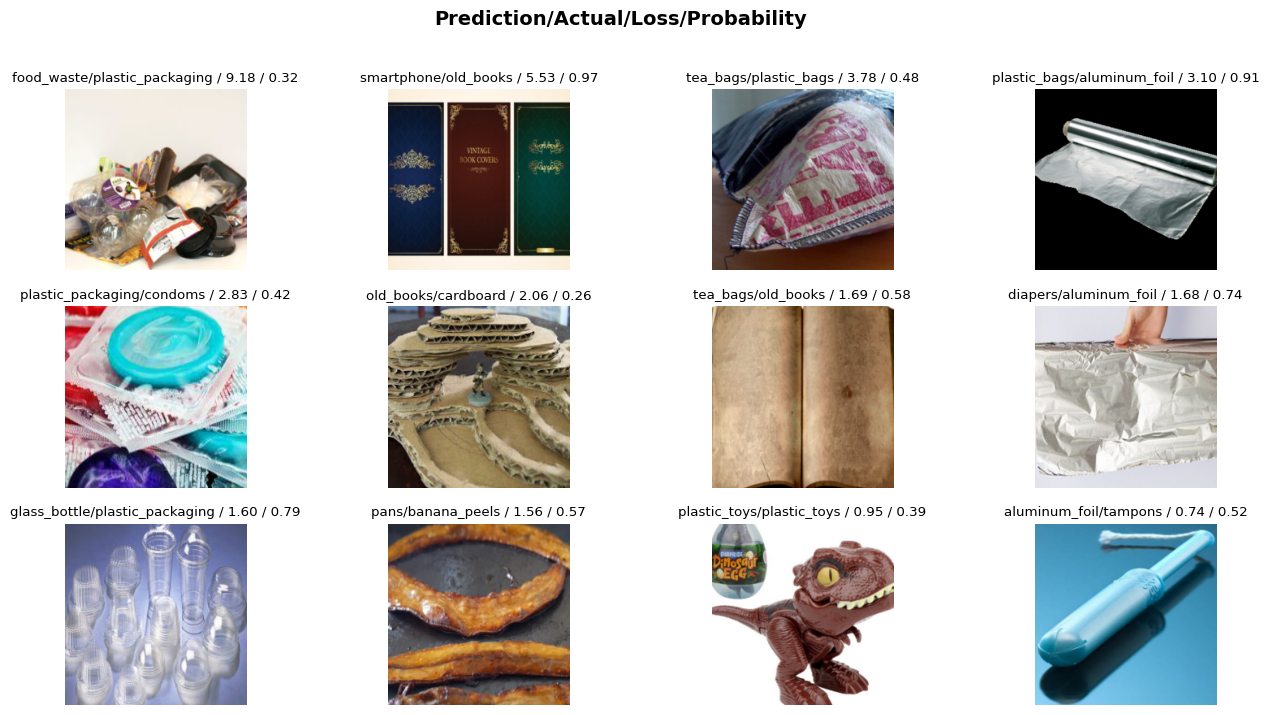

In [25]:
# plot the top losses
plt.rcParams.update({'font.size': 8})
interp_resnet34.plot_top_losses(12, nrows=3, figsize = (16, 8))

# ResNet50


In [ ]:
# define a learner
learn_resnet50 = vision_learner(dls, arch = resnet50, metrics=error_rate)

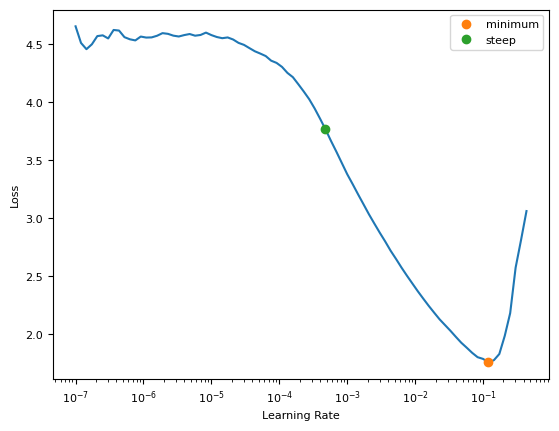

In [90]:
# determine optimum learning rate
lr_min_resnet50,lr_steep_resnet50 = learn_resnet50.lr_find(suggest_funcs=(minimum, steep))

In [91]:
# optimum learning rate
lr_steep_resnet50

0.0004786300996784121

In [92]:
# fine tune the learner for 14 epochs
learn_resnet50.fine_tune(14, base_lr = lr_steep_resnet50)

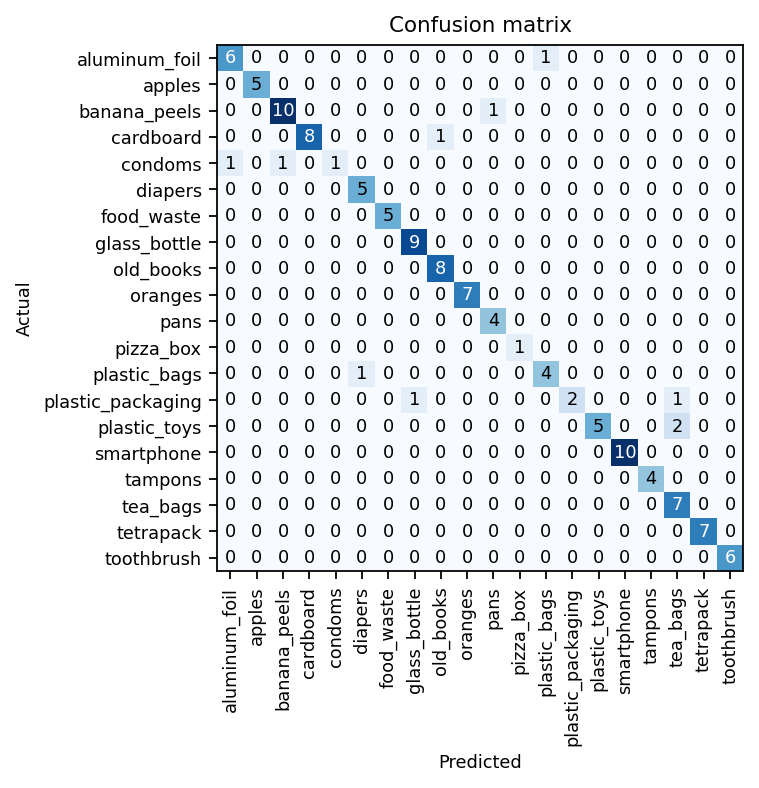

In [93]:
# plot the confusion matrix
plt.rcParams.update({'font.size': 8})
interp_resnet50 = ClassificationInterpretation.from_learner(learn_resnet50)
interp_resnet50.plot_confusion_matrix(dpi = 160)

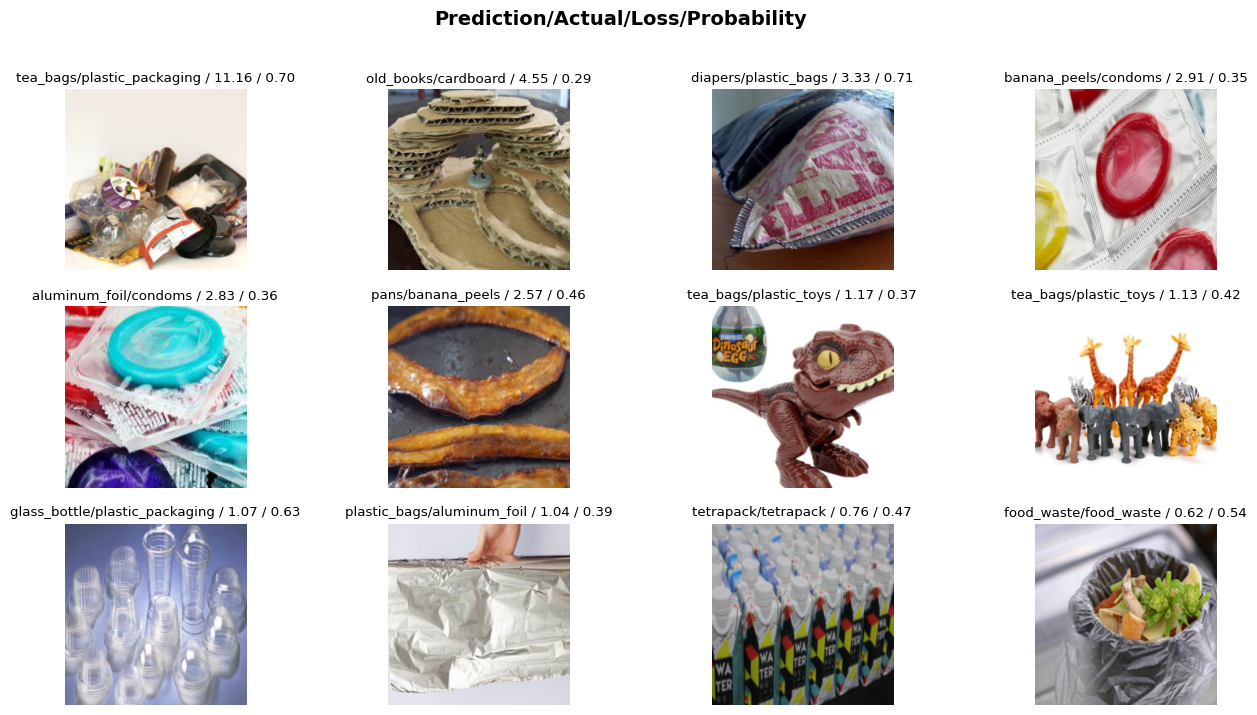

In [94]:
# plot the top losses
plt.rcParams.update({'font.size': 8})
interp_resnet50.plot_top_losses(12, nrows=3, figsize = (16, 8))

# ResNet101

In [ ]:
# define a learner
learn_resnet101 = vision_learner(dls, arch = resnet101, metrics=error_rate)

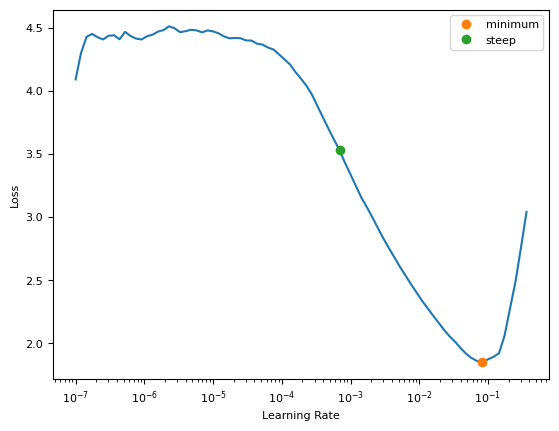

In [96]:
# determine optimum learning rate
lr_min_resnet101,lr_steep_resnet101 = learn_resnet101.lr_find(suggest_funcs=(minimum, steep))

In [97]:
# optimum learning rate
lr_steep_resnet101

0.0006918309954926372

In [98]:
# fine tune the learner for 16 epochs
learn_resnet101.fine_tune(16, base_lr = lr_steep_resnet101)

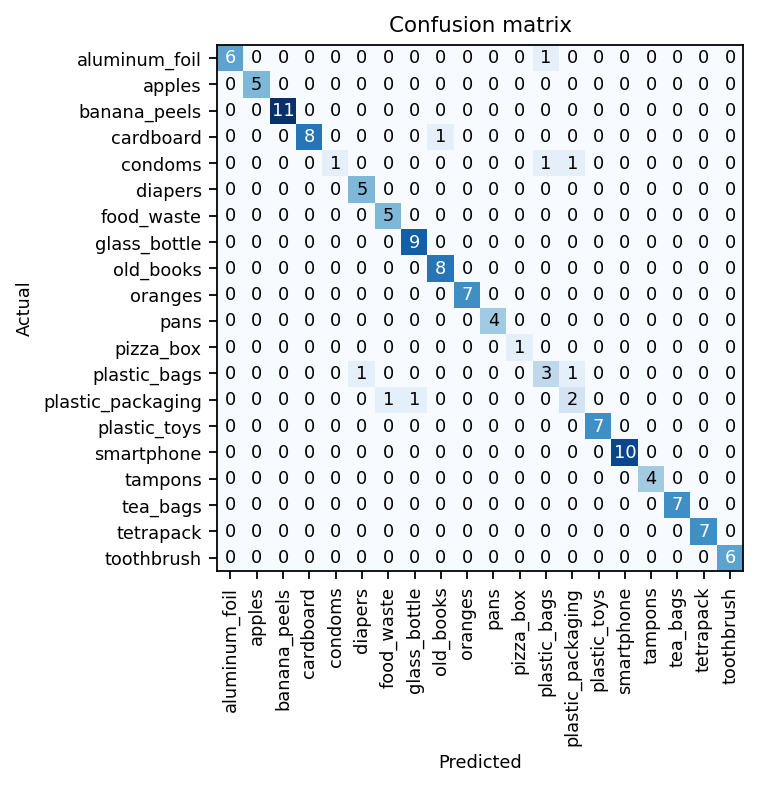

In [99]:
# plot the confusion matrix
plt.rcParams.update({'font.size': 8})
interp_resnet101 = ClassificationInterpretation.from_learner(learn_resnet101)
interp_resnet101.plot_confusion_matrix(dpi = 160)

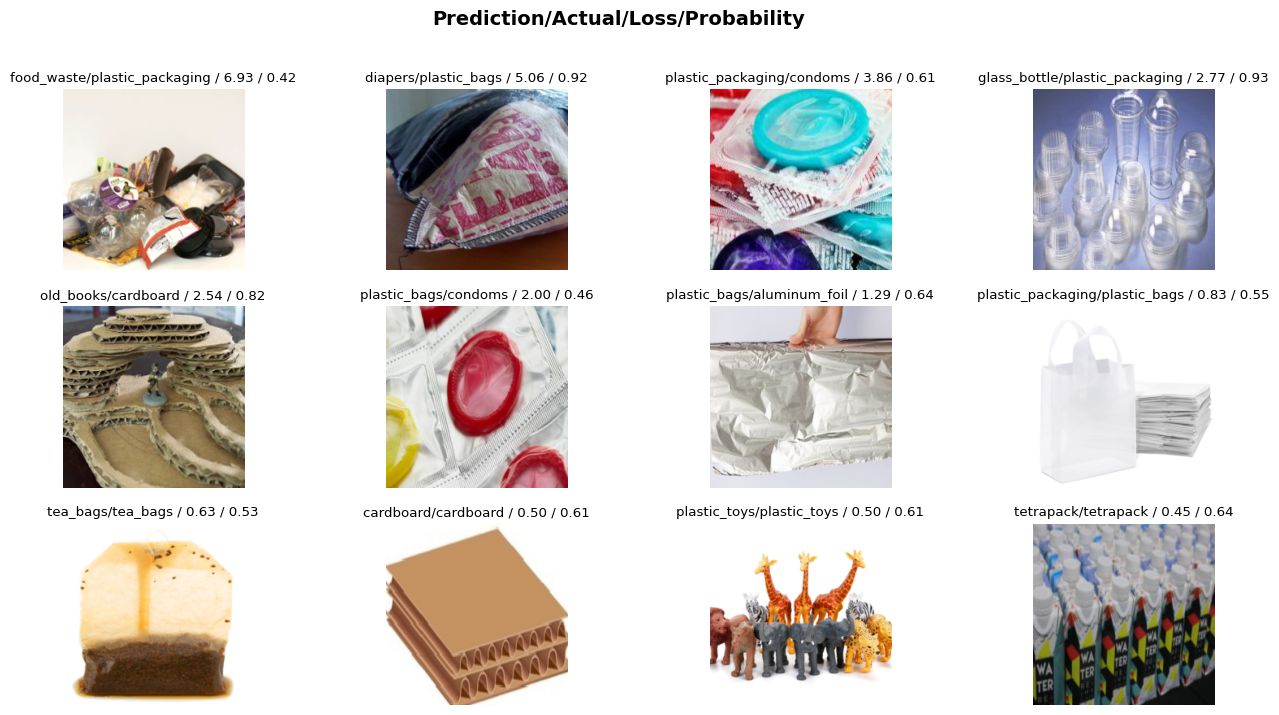

In [100]:
# plot the top losses
plt.rcParams.update({'font.size': 8})
interp_resnet101.plot_top_losses(12, nrows=3, figsize = (16, 8))

# ResNet152

In [14]:
# define a learner
learn_resnet152 = vision_learner(dls, arch = resnet152, metrics=error_rate)

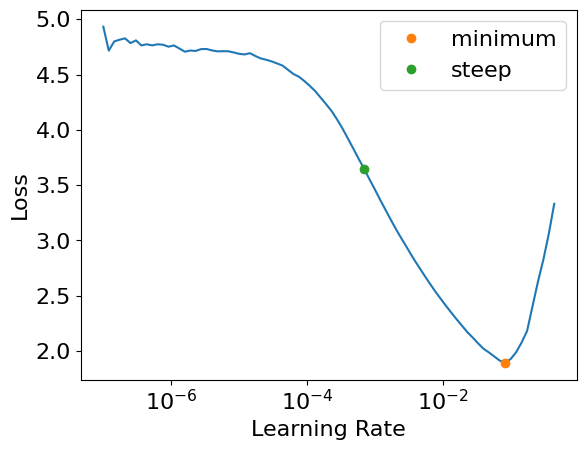

In [15]:
# determine optimum learning rate
lr_min_resnet152,lr_steep_resnet152 = learn_resnet152.lr_find(suggest_funcs=(minimum, steep))

In [16]:
# optimum learning rate
lr_steep_resnet152

0.0006918309954926372

In [17]:
# fine tune the learner for 18 epochs
learn_resnet152.fine_tune(18, base_lr = lr_steep_resnet152)

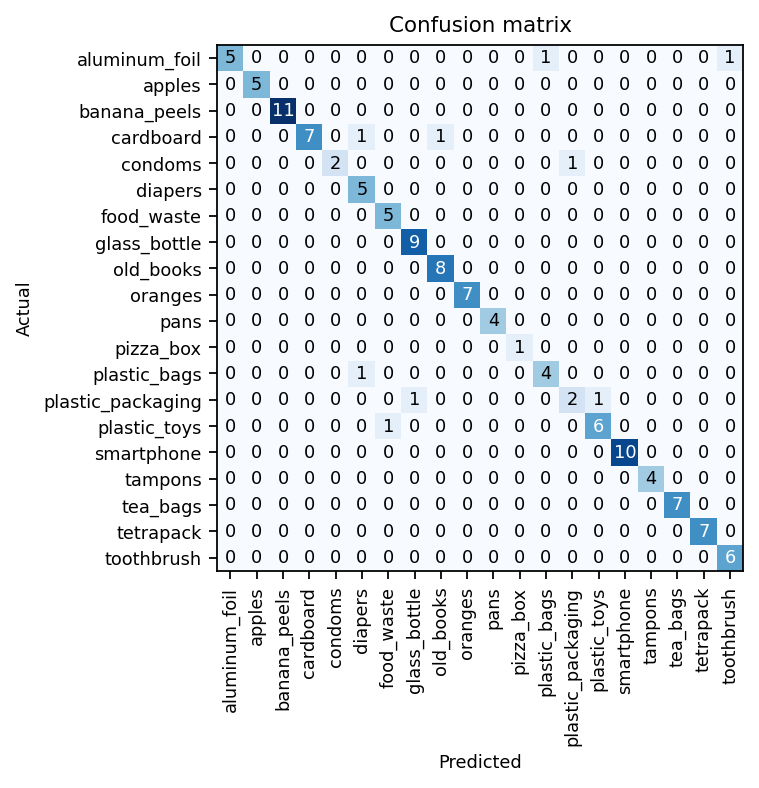

In [18]:
# plot the confusion matrix
plt.rcParams.update({'font.size': 8})
interp_resnet152 = ClassificationInterpretation.from_learner(learn_resnet152)
interp_resnet152.plot_confusion_matrix(dpi = 160)

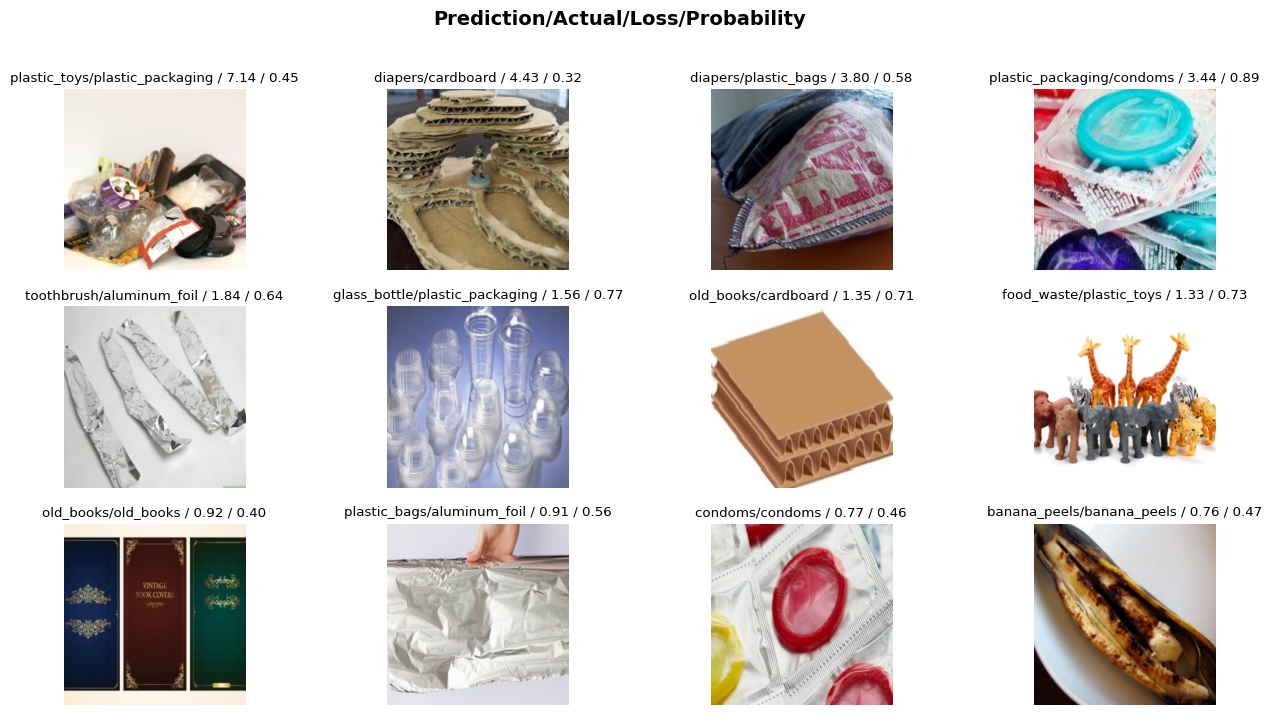

In [19]:
# plot the top losses
plt.rcParams.update({'font.size': 8})
interp_resnet152.plot_top_losses(12, nrows=3, figsize = (16, 8))

# Interpretation and Model Selection

## Model selection
- Best error rate while hopefully not overfitting: ResNet101, 4-6 epochs, but a lot of layers..
- More lightweight and reasonably good: ResNet50, 5-7 epochs
- ResNet18 and ResNet34: Error rate worse, but still okay
- ResNet152: Error rate is good, but model very large and complex, higher risk of overfitting, more memory and computing power needed

#### Final selection 
ResNet101, training for 5 epochs.

The model shows the best performance measured by error rate (= 0.0645 -> accuracy = 0.9355) and this is reached after training for 5 epochs. After training for longer, validation loss starts to converge slowly, while training loss still continues to decrease for a while and converges much later. This is a sign of overfitting.

In deployment, 101 layers will take more time per inference query than 50, but even using a CPU it still is reasonably fast. Should it turn out to take too long, the network can still be exchanged later.

One drawback, however, is that with 101 layers it needs 170 MB of memory, while the first prototype with 18 layers only needed 50 MB of memory. GitHub's file limitation is 100 MB, which is why I will not upload the exported model in our WasteWise repository. I will, however deploy it on Huggingface Spaces and post the link in the README.

# Training and Exporting the Final Model
Also perform one last interpretation of the model and this time go deeper into the details, since it is the final one (at least for now and until handing in).

In [ ]:
# define a learner
learn_final = vision_learner(dls, arch = resnet101, metrics=error_rate)

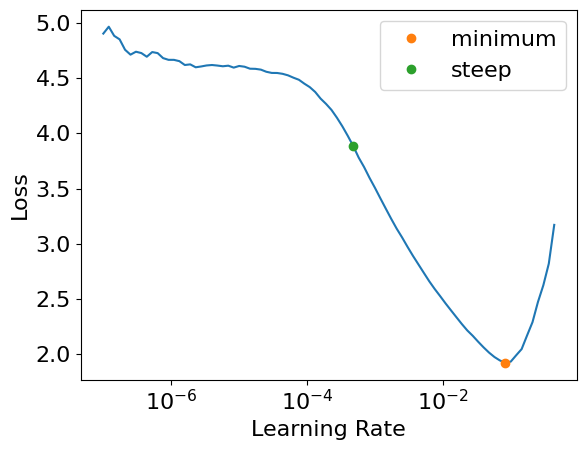

In [15]:
# determine optimum learning rate
lr_min_final,lr_steep_final = learn_final.lr_find(suggest_funcs=(minimum, steep))

In [16]:
# fine tune the learner for 5 epochs
learn_final.fine_tune(5, base_lr = lr_steep_final)

Comment: Seeing this, fine tuning for just 4 epochs might be even better. Error rate is lower at 5 epochs, but since the validation loss changes very lottle between epochs 4 and 5, generalisation might be better at 4 epochs. 

For testing this, it is important to have a test set, which we currently did not set up yet. We try to still implement that!

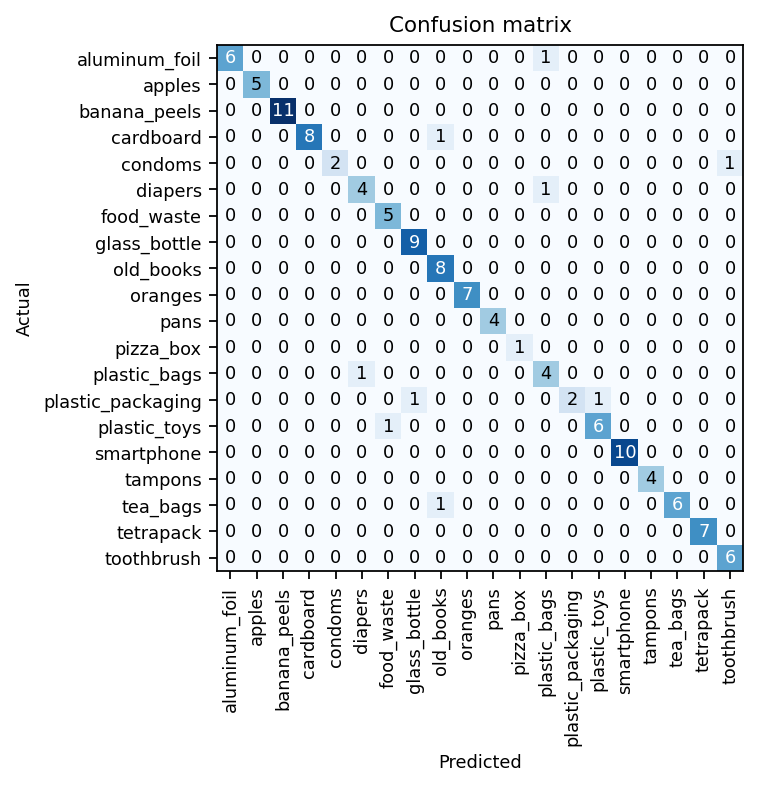

In [17]:
# plot the confusion matrix
plt.rcParams.update({'font.size': 8})
interp_final = ClassificationInterpretation.from_learner(learn_final)
interp_final.plot_confusion_matrix(dpi = 160)

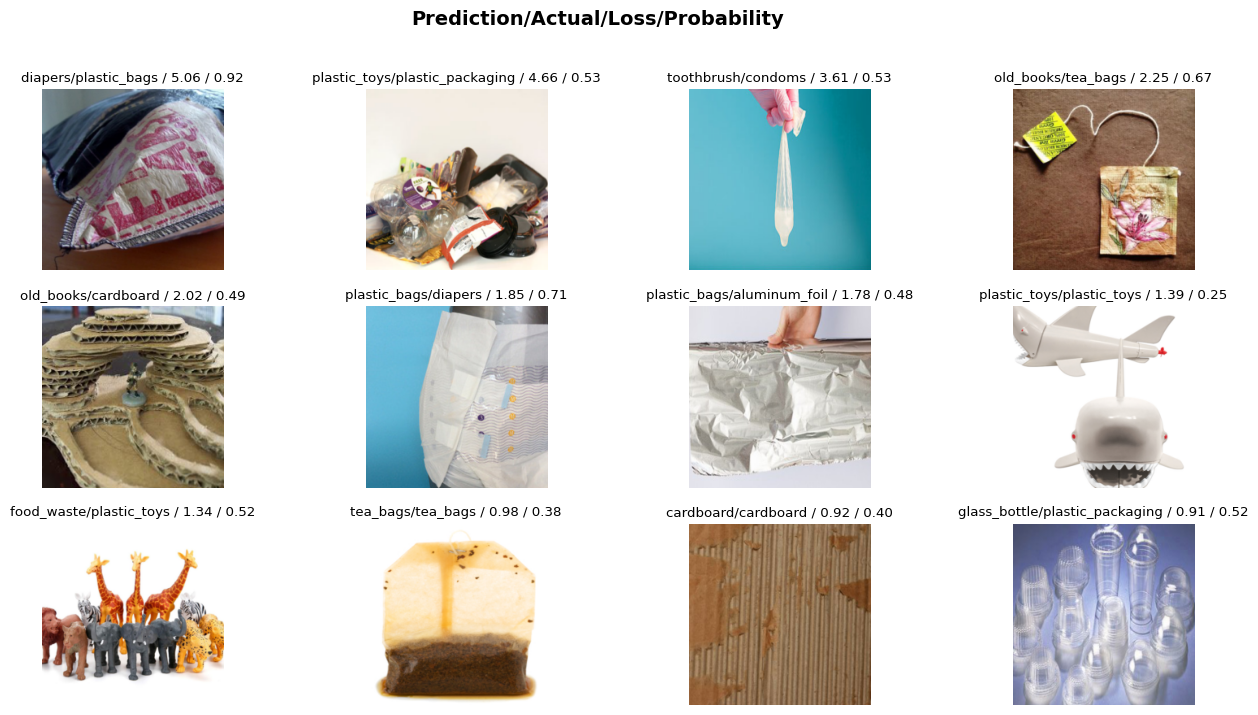

In [18]:
# plot the top losses
plt.rcParams.update({'font.size': 8})
interp_final.plot_top_losses(12, nrows=3, figsize = (16, 8))

In [20]:
# export the model to a file
# default name is "export.pkl", default directory is working directory
# adapt by passing a path to export method
# in export, this is fastai version 2, because previously there was one and there might be more in the future, we will see
learn_final.export("waste_recogniser_fastai_v2.pkl")

# Conclusion

## This is still work in progress

## To Dos
- Decide for final hyperparameters
- Think more about number of epochs. Avoid overfitting!
- Export model
- Make conclusions/interpretation final. Currently, it's just bullet points and not completely done
- Add more interpretations, refer to crowd sourced data, data mismatch and train-dev 

## Interpretation
- All models actually have very similar performance
- At first, I found that to be surprising
- However, then I had a look at the data and they all struggle with more or less the same. Then I was not surprised anymore
- Certain classes are hard to distinguish, e.g., condoms are within plastic packaging
- In the end it comes down to bad data. It is unrealistic

## What has not been done yet?
- There is just so much more that could have been done and we do not lack ideas, but at some point, focus needed to shift to more detailed interpretation. Another point we payed a lot of attention to was deployment, because even if it does not count as a requirement of our track and thus does not help us completing this course and project phase, we want to make it happen and get a complete and running app in the end!
- Train-dev/test set in order not to overfit the val set
- We only have a validation set, not a test set, but we have bad and too little data anyway. Still, because of this, we might have overfit the validation set.
- **Properly** determining optimum number of epochs